# NLP Group Project
### Alberto Puentes, Parker Voit, Tyler Applegate
#### Florence Cohort, 2021_08_03

In [1]:
# general imports
import requests
from requests import get
from bs4 import BeautifulSoup
import os
import re
import numpy as np
import pandas as pd
from markdown import markdown
import nltk
import csv
import pickle

# visualization imports
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, ImageColorGenerator
from pprint import pprint
from matplotlib import cm


# our function modules
import acquire
import prepare
import explore

# imports for modeling
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, recall_score, plot_confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

## Project Overview

## Key Findings:
- The goal of this project was to try and identify which programming language was used in a GitHub repository by scraping their respective readme.md files and constructing a classification model that would 'accurately' predict the programming language.
- We found that our K-Nearest Neighbors model outperformed all other models, including the baseline. 
- This model achieved 84% overall accuracy on our training data, 60% on our validate set, and finally 42% on the unseen test data set.
- With more time, we would like to gather more data, explore more methods for feature engineering new features for natural language processing, and use some more robust deep learning models. 

## Data Acquisition

In [2]:
# use our function to pull in raw data
repo_df = acquire.get_github_data(cached = True)

In [3]:
acquire.overview(repo_df)

This dataframe has 120 rows and 3 columns.
----------------------------------

<class 'pandas.core.frame.DataFrame'>
Int64Index: 120 entries, 0 to 119
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             120 non-null    object
 1   language         120 non-null    object
 2   readme_contents  119 non-null    object
dtypes: object(3)
memory usage: 3.8+ KB
None
----------------------------------

Unique value counts of each column

repo               120
language             4
readme_contents    119
dtype: int64
----------------------------------

Stats on Numeric Columns

                                  repo language  \
count                              120      120   
unique                             120        4   
top     /faridrashidi/kaggle-solutions     HTML   
freq                                 1       30   

                                          readme_contents  
count          

### Data Acquisition - Key Findings & Takeaways:
- We are looking at 120 observations, evenly distributed across 4 programming languages
- There appears to be 1 null value
- There are also multiple files that are in foreign languages
- For our first iteration, we are going to drop the null value, and foreign language repos

## Data Preparation

In [4]:
# perform our inital data prep and look at key stats
repo_clean = prepare.initial_repo_prep(repo_df, 'readme_contents', extra_words = ['fr','freesvghttpsgithubcomlisadziubaawesomedesigntoolsblobmastermediafreesvg','opensourcesvghttpsgithubcomlisadziubaawesomedesigntoolsblobmastermediaopensourcesvg'])

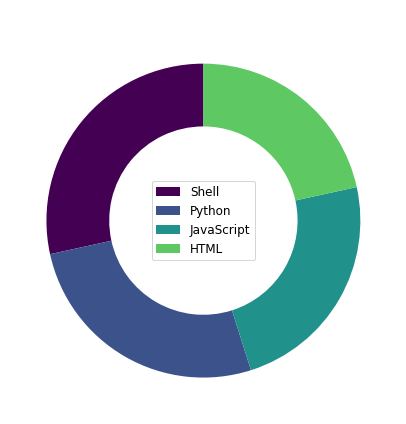

In [5]:
# visualize distribution of target variable
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(aspect="equal"))
cs_customer= cm.get_cmap('viridis')(np.linspace(0, 1, 5))
language = ['Shell', 'Python', 'JavaScript', 'HTML']
data = [29,27,24,22]
wedges, texts = ax.pie(data, wedgeprops=dict(width=0.4), startangle=90,colors=cs_customer)
plt.legend(wedges, language, loc="center",fontsize=12)
ax.set_title("Language Distribution", color="white", fontdict={'fontsize': 16, 'fontweight': 'bold'})
fig.tight_layout()
plt.savefig('donutplot2.png',dpi=100, format='png', bbox_inches='tight')
plt.show()

In [6]:
# split our data prior to exploration, stratifying on target variable 'language'
train, validate, test = prepare.train_validate_test_split(repo_clean, 'language')

In [7]:
# what does our training set look like?
acquire.overview(train)

This dataframe has 56 rows and 6 columns.
----------------------------------

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56 entries, 86 to 3
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   repo                        56 non-null     object
 1   language                    56 non-null     object
 2   readme_contents             56 non-null     object
 3   cleaned_readme_contents     56 non-null     object
 4   stemmed_readme_contents     56 non-null     object
 5   lemmatized_readme_contents  56 non-null     object
dtypes: object(6)
memory usage: 3.1+ KB
None
----------------------------------

Unique value counts of each column

repo                          56
language                       4
readme_contents               56
cleaned_readme_contents       56
stemmed_readme_contents       56
lemmatized_readme_contents    56
dtype: int64
----------------------------------

Stats on

### Data Preparation - Key Findings & Takeaways:
- We dropped 1 null observation, and 17 foreign language repos
- We also created new columns of 'cleaned', 'stemmed', and 'lemmatized' data
- Due to dropping the foreign language repos, our distribution is no longer uniform across the 4 programming languages
- Instead of 30 each, we now have:
    - 29 Shell
    - 27 Python
    - 24 JavaScript
    - 22 HTML
- We are hopeful that this imbalance will not impact our modeling too much
- If it does, we will end up having to pull in more data
- Data has been split into train, validate, and test sets that have been stratified on 'language' to keep as much balance as possible to each dataset

## Data Exploration

In [8]:
# create lists of all words, java words, html words, python words, and shell words
all_words = (' '.join(train.cleaned_readme_contents))
java_words = (' '.join(train[train.language == 'JavaScript'].cleaned_readme_contents))
shell_words = (' '.join(train[train.language == 'Shell'].cleaned_readme_contents))
python_words = (' '.join(train[train.language == 'Python'].cleaned_readme_contents))
html_words = (' '.join(train[train.language == 'HTML'].cleaned_readme_contents))

In [9]:
# convert the lists to number counts of each word
all_freq = pd.Series(all_words.split()).value_counts()
java_freq = pd.Series(java_words.split()).value_counts()
shell_freq = pd.Series(shell_words.split()).value_counts()
python_freq = pd.Series(python_words.split()).value_counts()
html_freq = pd.Series(html_words.split()).value_counts()

In [10]:
# create a dictionary to save words to be parsed later
documents = {'java': java_words,
            'python': python_words,
            'HTML': html_words,
            'shell': shell_words}

In [11]:
# A simple way to calculate idf for demonstration. Note that this
# function relies on the globally defined documents variable.
def idf(word):
    n_occurences = sum([1 for doc in documents.values() if word in doc])
    return len(documents) / n_occurences

# Get a list of the unique words
unique_words = pd.Series(' '.join(documents.values()).split()).unique()

# put the unique words into a data frame
dfx = (pd.DataFrame(dict(word=unique_words))
 # calculate the idf for each word
 .assign(idf=lambda df: df.word.apply(idf))
 # sort the data for presentation purposes
 .set_index('word')
 .sort_values(by='idf', ascending=True))

In [12]:
stop_words = dfx[dfx.idf<2]

In [13]:
repo_clean = prepare.second_repo_prep(repo_df, 'readme_contents', extra_words = stop_words)

In [14]:
train, validate, test = prepare.train_validate_test_split(repo_clean, 'language')

In [15]:
this_list = [all_words, java_words, shell_words, python_words, html_words]
that_list = ['all_words', 'java_words', 'shell_words', 'python_words', 'html_words']

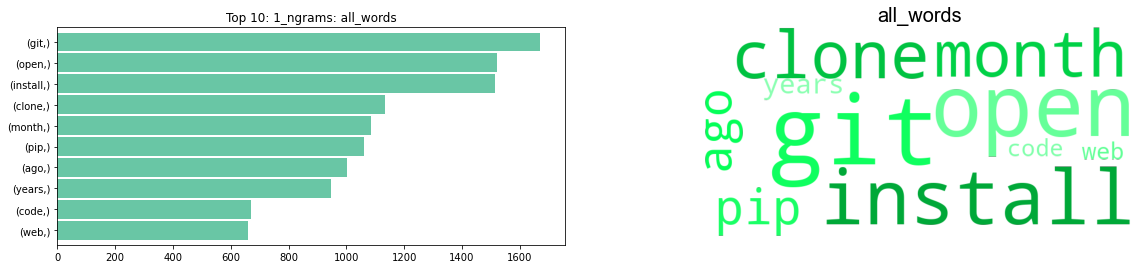

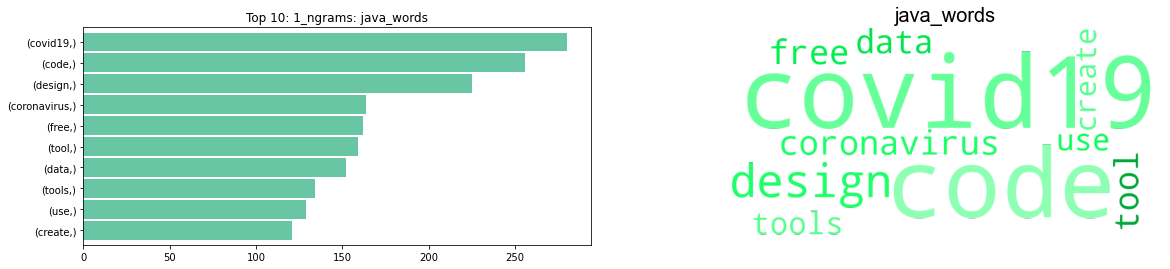

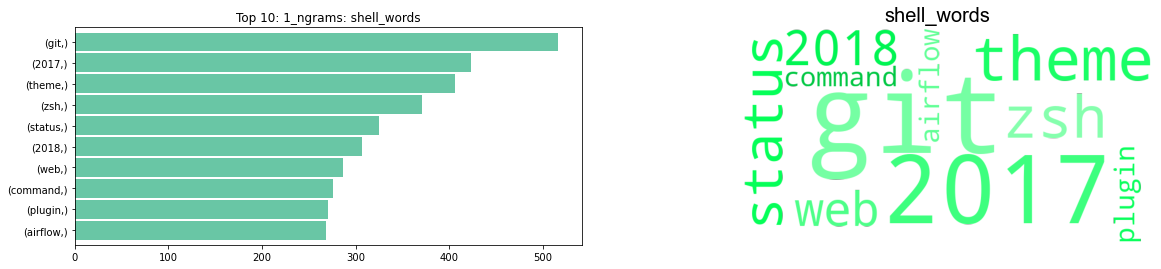

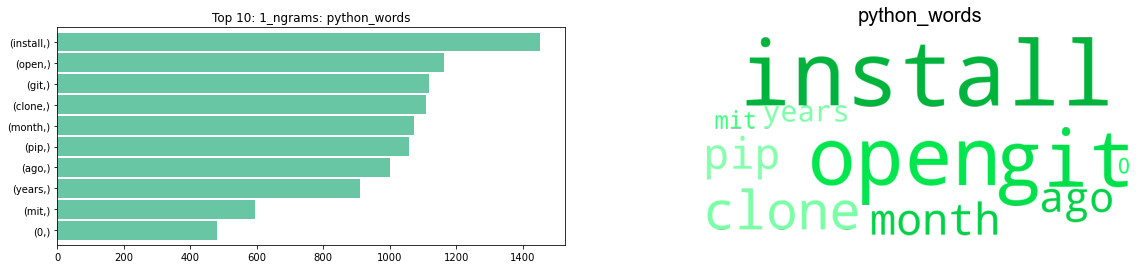

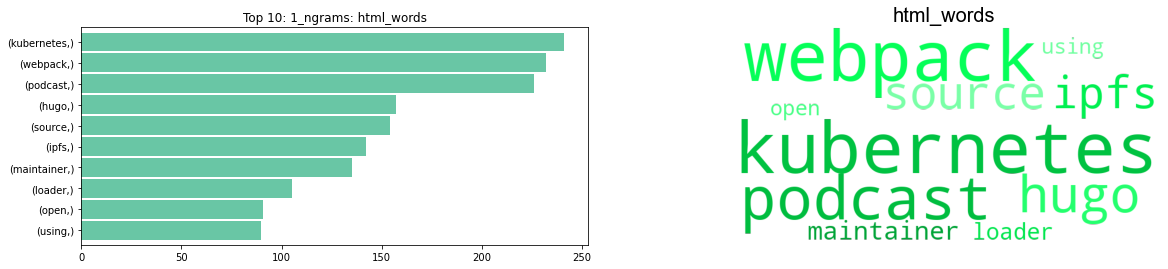

In [16]:
# let's look at the top 10 words for each language
explore.word_count_word_cloud(this_list, that_list)

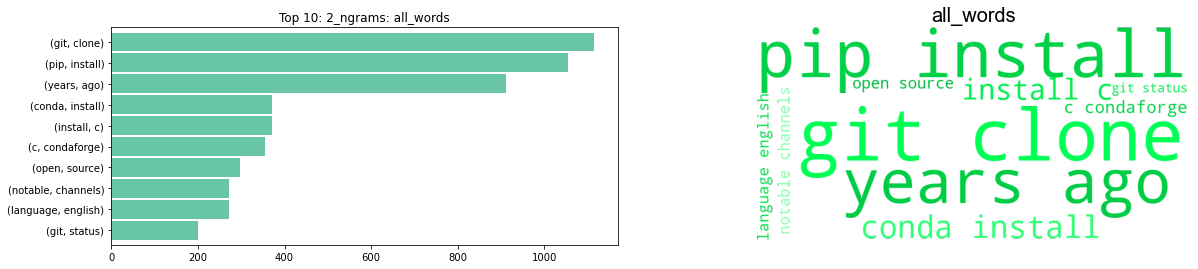

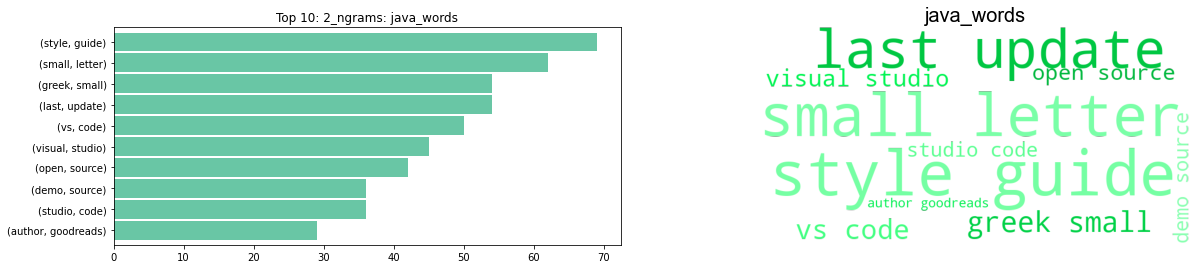

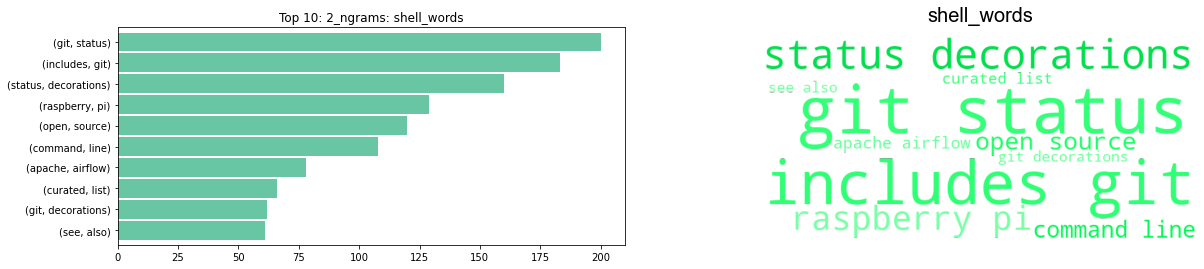

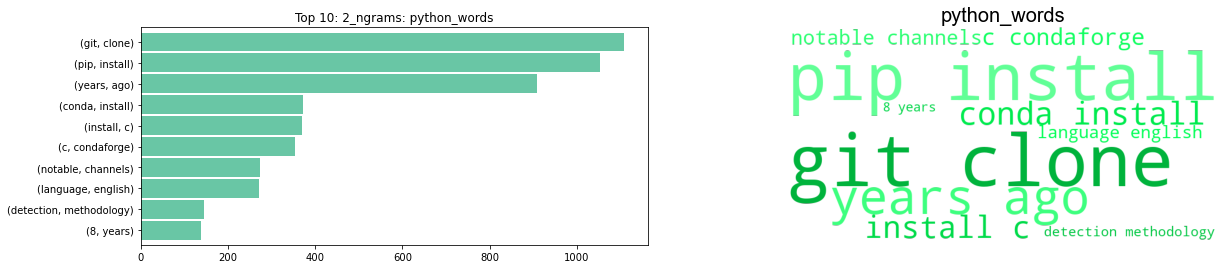

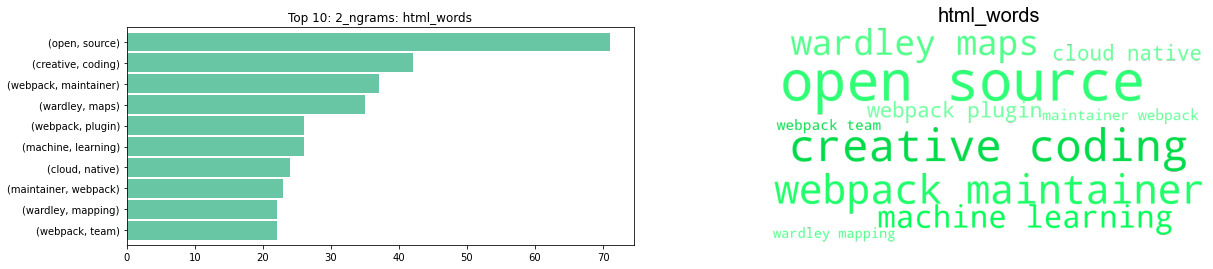

In [17]:
# now let's look at bigrams
explore.bigram_word_cloud(this_list, that_list, n = 2, x=10)

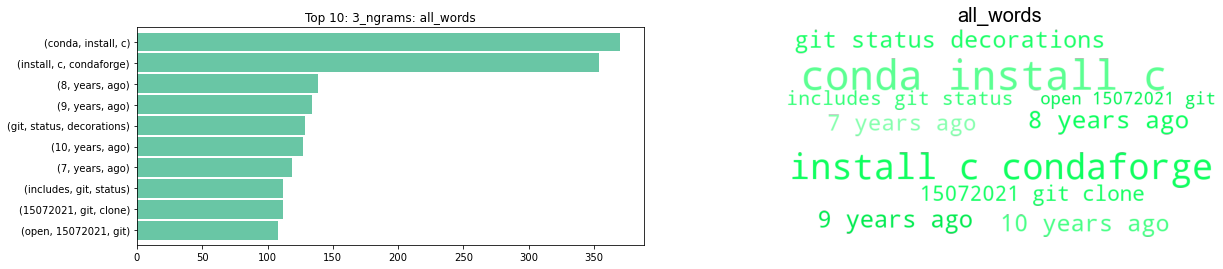

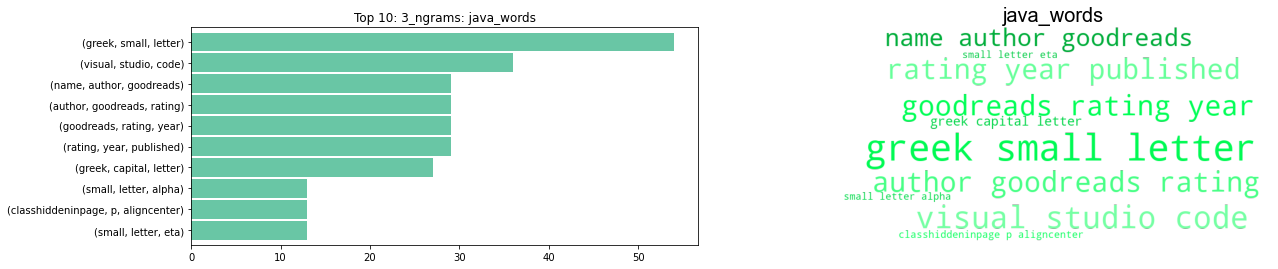

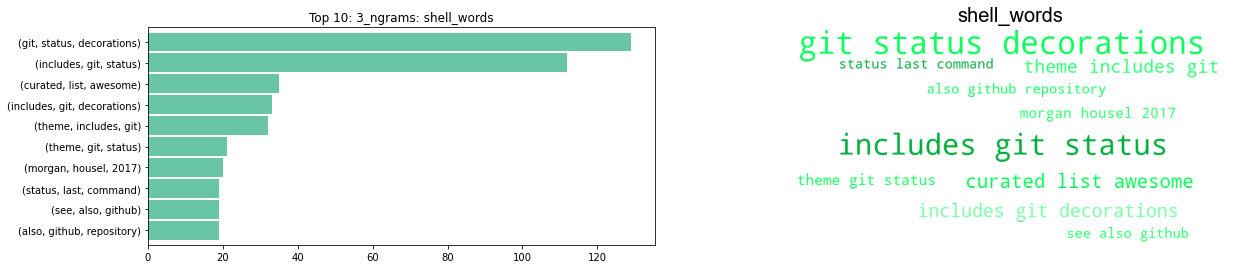

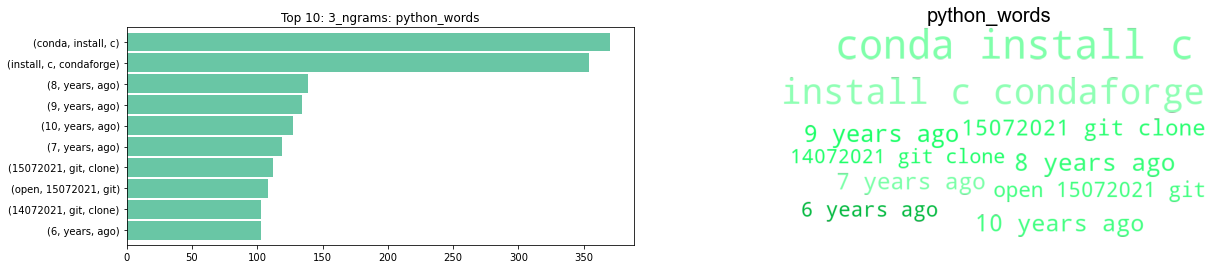

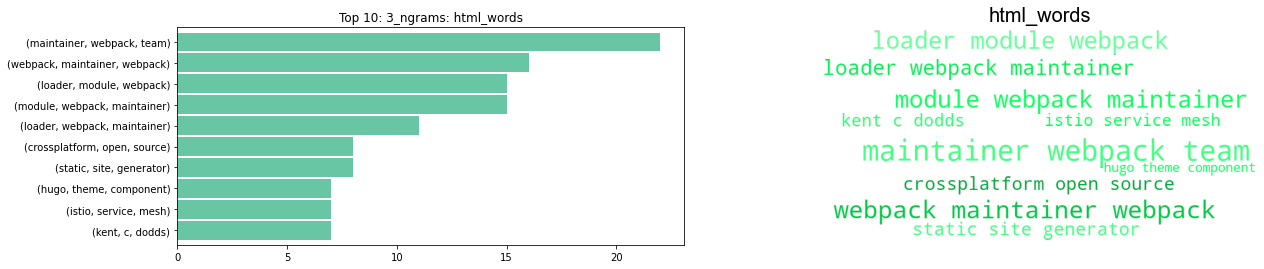

In [18]:
# and finally, let's see trigrams...
explore.trigram_word_cloud(this_list, that_list, n = 3, x=10)

In [19]:
train['length'] = [len(i) for i in train.cleaned_readme_contents]
train.groupby(by = 'language').mean().round(0)

,length
language,
HTML,13579.0
JavaScript,27287.0
Python,42318.0
Shell,36905.0


### Data Exploration - Key Findings & Takeaways:
- Most Common Single Words:
    - Quite a bit of overlap between languages
    - Each language appears to have a few words that are exclusive to their top used list
    - Looks like we need to drop some of the most common words across all languages, to get more value out of single words
- Most Common Bigrams:
    - Less overlap than on single words, but still a little too much
    - We are starting to see a different vocabulary for each programming language emerge
    - Will get more value after dropping most common words across all languages
- Most Common Trigrams:
    - Very interesting to see how many trigrams are made up of overlapping bigrams
    - Least amount of overlap here, and interesting to see how many words appear in multiple trigrams for a language
- Length Takeaways:
    - Python has the largest average character count 
    - JavaScript and Shell have somewhat equal character counts
    - HTML has the least amount
    - There is an imbalance here that ideally would be addressed with more time, to avoid over-fitting of models
- With More Time:
    - Explore various feature engineering, such as bigrams, trigrams, length of document, and sentiment analysis
    - Experiment with additional / fewer stopwords
    - Gather more data

## Model Building

In [20]:
# Setup our X variables
X_train = train.lemmatized_readme_contents
X_validate = validate.lemmatized_readme_contents
X_test = test.lemmatized_readme_contents

# Setup our y variables
y_train = train.language
y_validate = validate.language
y_test = test.language

In [21]:
train.language.value_counts()
# establish a baseline using the most common value
train['baseline'] = 'Shell'

In [22]:
baseline = (train.baseline == y_train).mean()
print(f'Baseline accuracy is {baseline * 100:.2f}%')

Baseline accuracy is 28.57%


In [23]:
# Create the tfidf vectorizer object
tfidf = TfidfVectorizer()

# Fit the object on the training data
tfidf.fit(X_train)

# Save as vectorized object
X_train_vectorized = tfidf.transform(X_train)
X_validate_vectorized = tfidf.transform(X_validate) 
X_test_vectorized = tfidf.transform(X_test)

In [24]:
#Create the RF object
rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=20,
                            max_depth=5, 
                            random_state=123)

#Fit the RF object to the training data
rf.fit(X_train_vectorized, y_train)

#Predict on y
y_pred = rf.predict(X_train_vectorized)
rf.score(X_train_vectorized, y_train)
#Evaluate
print(classification_report(y_train, y_pred, zero_division = 0))
print(f'Model accuracy is {rf.score(X_train_vectorized, y_train)*100:.2f}%')
print(f'Baseline accuracy is {baseline * 100:.2f}%')

              precision    recall  f1-score   support

        HTML       0.00      0.00      0.00        12
  JavaScript       0.00      0.00      0.00        13
      Python       0.00      0.00      0.00        15
       Shell       0.29      1.00      0.44        16

    accuracy                           0.29        56
   macro avg       0.07      0.25      0.11        56
weighted avg       0.08      0.29      0.13        56

Model accuracy is 28.57%
Baseline accuracy is 28.57%


In [25]:
y_pred = rf.predict(X_validate_vectorized)
print(classification_report(y_validate, y_pred, zero_division=0))
print(f'Model accuracy is {rf.score(X_validate_vectorized, y_validate)*100:.2f}%')
print(f'Baseline accuracy is {baseline * 100:.2f}%')

              precision    recall  f1-score   support

        HTML       0.00      0.00      0.00         6
  JavaScript       0.00      0.00      0.00         6
      Python       0.00      0.00      0.00         6
       Shell       0.28      1.00      0.44         7

    accuracy                           0.28        25
   macro avg       0.07      0.25      0.11        25
weighted avg       0.08      0.28      0.12        25

Model accuracy is 28.00%
Baseline accuracy is 28.57%


In [26]:
#Make the CLF object
clf = DecisionTreeClassifier(max_depth=4, random_state=123, min_samples_leaf = 10)

#Fit the model on the training set 
clf = clf.fit(X_train_vectorized, y_train)

#Make predictions
y_pred = clf.predict(X_train_vectorized)

#Evaluate model performance on training data
print(classification_report(y_train, y_pred,zero_division=0))
print(f'Model accuracy is {clf.score(X_train_vectorized, y_train)*100:.2f}%')
print(f'Baseline accuracy is {baseline * 100:.2f}%')

              precision    recall  f1-score   support

        HTML       0.56      0.75      0.64        12
  JavaScript       0.60      0.46      0.52        13
      Python       1.00      0.67      0.80        15
       Shell       0.70      0.88      0.78        16

    accuracy                           0.70        56
   macro avg       0.72      0.69      0.69        56
weighted avg       0.73      0.70      0.70        56

Model accuracy is 69.64%
Baseline accuracy is 28.57%


In [27]:
y_pred = clf.predict(X_validate_vectorized)
print(classification_report(y_validate, y_pred, zero_division=0))
print(f'Model accuracy is {clf.score(X_validate_vectorized, y_validate)*100:.2f}%')
print(f'Baseline accuracy is {baseline * 100:.2f}%')

              precision    recall  f1-score   support

        HTML       0.67      0.67      0.67         6
  JavaScript       0.33      0.17      0.22         6
      Python       0.33      0.17      0.22         6
       Shell       0.38      0.71      0.50         7

    accuracy                           0.44        25
   macro avg       0.43      0.43      0.40        25
weighted avg       0.43      0.44      0.41        25

Model accuracy is 44.00%
Baseline accuracy is 28.57%


In [28]:
#Make the naive bayes object
nb = MultinomialNB()

#Fit the model on the training set 
nb = nb.fit(X_train_vectorized, y_train)

#Make predictions
y_pred = nb.predict(X_train_vectorized)

#Evaluate model performance on training data
print(classification_report(y_train, y_pred))
print(f'Model accuracy is {nb.score(X_train_vectorized, y_train)*100:.2f}%')
print(f'Baseline accuracy is {baseline * 100:.2f}%')

              precision    recall  f1-score   support

        HTML       1.00      0.83      0.91        12
  JavaScript       1.00      1.00      1.00        13
      Python       1.00      1.00      1.00        15
       Shell       0.89      1.00      0.94        16

    accuracy                           0.96        56
   macro avg       0.97      0.96      0.96        56
weighted avg       0.97      0.96      0.96        56

Model accuracy is 96.43%
Baseline accuracy is 28.57%


In [29]:
#Make predictions
y_pred = nb.predict(X_validate_vectorized)

#Evaluate model performance on training data
print(classification_report(y_validate, y_pred))
print(f'Model accuracy is {nb.score(X_validate_vectorized, y_validate)*100:.2f}%')
print(f'Baseline accuracy is {baseline * 100:.2f}%')

              precision    recall  f1-score   support

        HTML       0.00      0.00      0.00         6
  JavaScript       0.00      0.00      0.00         6
      Python       1.00      0.50      0.67         6
       Shell       0.29      0.86      0.43         7

    accuracy                           0.36        25
   macro avg       0.32      0.34      0.27        25
weighted avg       0.32      0.36      0.28        25

Model accuracy is 36.00%
Baseline accuracy is 28.57%


In [30]:
# create KNN classifier object
knn = KNeighborsClassifier(n_neighbors=2, weights='uniform')

# fit the model to vectorized data
knn.fit(X_train_vectorized, y_train)
y_pred = knn.predict(X_train_vectorized)


print(classification_report(y_train, y_pred))
print(f'Model accuracy is {knn.score(X_train_vectorized, y_train)*100:.2f}%')
print(f'Baseline accuracy is {baseline * 100:.2f}%')

              precision    recall  f1-score   support

        HTML       0.75      1.00      0.86        12
  JavaScript       0.76      1.00      0.87        13
      Python       0.92      0.73      0.81        15
       Shell       1.00      0.69      0.81        16

    accuracy                           0.84        56
   macro avg       0.86      0.86      0.84        56
weighted avg       0.87      0.84      0.84        56

Model accuracy is 83.93%
Baseline accuracy is 28.57%


In [31]:
y_pred = knn.predict(X_validate_vectorized)
print(classification_report(y_validate, y_pred, zero_division=0))
print(f'Model accuracy is {knn.score(X_validate_vectorized, y_validate)*100:.2f}%')
print(f'Baseline accuracy is {baseline * 100:.2f}%')

              precision    recall  f1-score   support

        HTML       0.56      0.83      0.67         6
  JavaScript       0.50      0.83      0.62         6
      Python       1.00      0.67      0.80         6
       Shell       0.50      0.14      0.22         7

    accuracy                           0.60        25
   macro avg       0.64      0.62      0.58        25
weighted avg       0.63      0.60      0.56        25

Model accuracy is 60.00%
Baseline accuracy is 28.57%


### Model Building - Key Findings & Takeaways:

- All models passed the baseline on the validate split, except for the Random Forest Classifier
- All models are overfit
- K-Nearest Neighbors performed the best, outperforming the baseline by 31.43%
    - Model efficacy could be improved by increasing the amount of readmes in the dataset
    - Readme length also greatly varied across languages which creates a psuedo-class imbalance. Finding a method to scale readme length would help reduce overfitting
    - Further hyper-parameter tuning and feature engineering could help generalize the model better
- Most were pretty imbalanced when predicting all four languages, but K-Nearest Neighbors predicted all but shell somewhat equally
- For these reasons, we will use KNN on the test set
- With More Time:
    - All models would benefit greatly from an increased sample size
    - We found that distance-based models outperformed decision-based models, and would like to continue adjusting hyperparameters
    - We would also like to look into clustering, and combining models to increase accuracy

## Model Evaluation

In [32]:
y_pred = knn.predict(X_test_vectorized)
print(classification_report(y_test, y_pred))
print(f'Model accuracy on test (unseen data) is {knn.score(X_test_vectorized, y_test)*100:.2f}%')
print(f'Baseline accuracy is {baseline * 100:.2f}%')

              precision    recall  f1-score   support

        HTML       0.43      0.75      0.55         4
  JavaScript       0.50      0.40      0.44         5
      Python       0.67      0.33      0.44         6
       Shell       0.29      0.33      0.31         6

    accuracy                           0.43        21
   macro avg       0.47      0.45      0.44        21
weighted avg       0.47      0.43      0.42        21

Model accuracy on test (unseen data) is 42.86%
Baseline accuracy is 28.57%


### Model Evaluation - Key Findings & Takeaways:
- The model outperformed the baseline by 15% and was not too lopsided in predicting each language
- The model performed very well in predicting HTML code
- Performs the worst with Shell
- More data is needed to increase K and reduce overfitting

In [33]:
# Pickle it for later 
filename = 'knn_github_model.sav'
pickle.dump(knn, open(filename, 'wb'))
 
# load the model from disk to test
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test_vectorized, y_test)
print(f'Model accuracy score on input data: {result:.2f}%')

Model accuracy score on input data: 0.43%


## Final Conclusions & Next Steps: 
- Conclusions:
    - It is possible to predict coding languages based off of readme files alone
    - Special care needs to be taken during the cleaning phase of the pipeline as the quality of words fed into the algorithm is crucial to model performance
    - Domain knowledge is important for determining important stop words 
    - TF-IDF vectorizing worked better for this data
    - More data could help with overfitting, or possibly addressing the imbalanced character counts for each language's readme.

- Next Steps 
    - All models would benefit greatly from an increased sample size
    - We found that distance-based models outperformed decision-based models, and would like to continue adjusting hyperparameters
    - We would also like to look into clustering, and combining models to increase accuracy